Данный проект исследует лучшие университеты мира с сайта UNIPAGE, где есть данные о таких реайтингах как QS, THE и ARWU. 

In [7]:
#импортируем библиотеки
import requests
from bs4 import BeautifulSoup as bs
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sqlalchemy import create_engine

Код ниже, парсит данные с сайта UNIPAGE и сразу же записыват в файл universities.csv. Стоит отметить, что цену бакалавриата, магистратуры и докторантуры я записывал среднюю. То есть, на некоторых университетах был разброс цен ОТ и ДО, откуда я и брал среднюю. Также, на более дальних местах в рейтингах не указано точное место(например, там указано 750-800 или же 1500+), в таком случае я записывал места по рейтингам в том порядке в котором они встречались. 

In [24]:
with open('universities.csv', 'w', newline='') as file:
    dct = {'Название': None, 'Место в рейтинге': None, 'Расположение': None, 'Бакалавриат': None, 'Магистратура': None,
           'Докторантура': None, 'QS': None, 'THE': None, 'ARWU': None}
    csv.writer(file).writerow(dct.keys())
    counter = 1
    dct1 = {'THE': [], 'QS': [], 'ARWU': []}
    for i in range(1, 73): #это внешний цикл по страницам, всего их 72
        req = requests.get(f"https://www.unipage.net/ru/universities?limit=500&page={i}")
        src = req.text
        soup = bs(src, 'html.parser')
        items = soup.find_all("article", class_="generated-card")
        for j in range(len(items)): #это цикл, который спускается в конкретный университет
            dct = {'Название': None, 'Место в рейтинге': None, 'Расположение': None, 'Бакалавриат': None,
                   'Магистратура': None, 'Докторантура': None}
            name = items[j].find('a').get_text()
            dct['Название']=name
            dct['Место в рейтинге']=counter
            counter += 1
            try:
                country = items[j].find_all('span')[1].find('a').get_text() #Парсер ломается на Донецком государственном университете Xd.. Не указали страну
            except:
                country = None
            dct['Расположение']=country
            grades = items[j].find_all('dt', class_='content-card__title')
            price = items[j].find_all('span', class_='content-card-number__number')
            for k in range(len(grades)): #это цикл, который спускается в цены бакалавриата магистратуры и аспирантуры
                try: #использую, потому что на некоторых университетах не написана цена ДО
                    dct[grades[k].get_text()] = (int(price[k].get_text().replace('\xa0', '')) + int(price[k + 1].get_text().replace('\xa0', '')))/2
                except:
                    dct[grades[k].get_text()] = int(price[k].get_text().replace('\xa0', ''))
            ratings = items[j].find_all('span', class_='tag tag_size_s tag_secondary')
            for h in range(len(ratings)): #этот цикл спускается в места по разным рейтингам
                rt = ratings[h].get_text().split()
                check = dct1[rt[2]]
                try:
                    dct[rt[2]] = int(rt[1])
                except:
                    num = int(rt[1].split('-')[0].strip('+'))
                    while num in check:
                        num += 1
                    dct1[rt[2]].append(num)
                    dct[rt[2]] = num
            csv.writer(file).writerow(dct.values()) #Записываем данные по одному университету

In [9]:
#Сделаем датафрейм из csv файла, который мы только что сделали и смотрим что получилось
df = pd.read_csv('universities.csv')
df.head(10)

,Название,Место в рейтинге,Расположение,Бакалавриат,Магистратура,Докторантура,QS,THE,ARWU
0,Гарвардский университет,1,США,30281.5,30196.5,NaN,4.0,4.0,1.0
1,Массачусетский технологический институт,2,США,58224.0,58224.0,58224.0,1.0,3.0,3.0
2,Стэнфордский университет,3,США,57678.0,57075.0,NaN,5.0,2.0,2.0
3,Кембриджский университет,4,Великобритания,34218.0,27337.0,36828.5,2.0,5.0,4.0
4,Калифорнийский технологический институт,5,США,48098.0,48098.0,NaN,15.0,7.0,9.0
5,Оксфордский университет,6,Великобритания,28101.0,27707.0,44546.0,3.0,1.0,7.0
6,Принстонский университет,7,США,55995.0,54935.5,NaN,17.0,6.0,6.0
7,Чикагский университет,8,США,59240.0,54480.5,NaN,11.0,10.0,NaN
8,Университетский колледж Лондона,9,Великобритания,24430.0,24290.0,NaN,9.0,22.0,17.0
9,Йельский университет,10,США,59934.0,42938.5,50211.5,16.0,10.0,11.0


array([<Axes: ylabel='count'>], dtype=object)

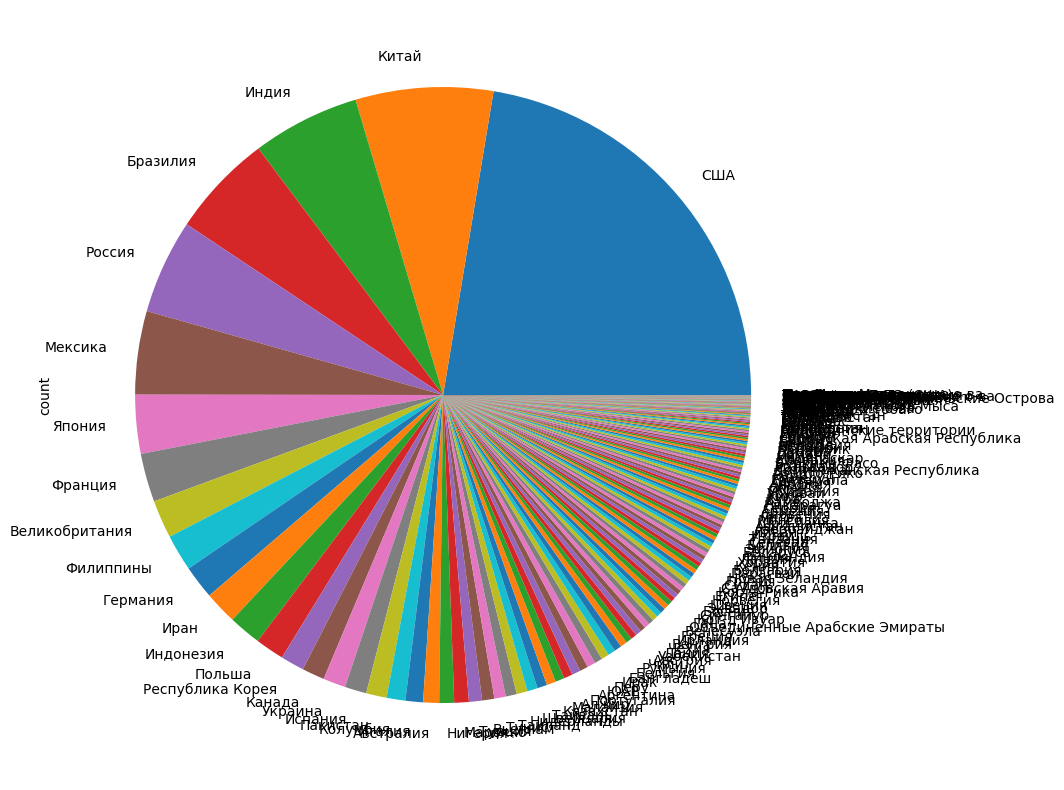

In [123]:
#Нарисуем диаграмму по количеству университетов в списке лучших по странам
result = df['Расположение'].value_counts()
result.plot.pie(figsize=(10, 10), subplots=True)

Из интересных наблюдений здесь, можно увидеть, что университетов Великобритании не так уж и много, как могло казаться до визуализации. 

Проверим гипотезу о том, что чем выше университет в рейтинге тем дороже там образование(некоторые люди думают, что это лишь маркетинг направленный на установку более высокой цены) 

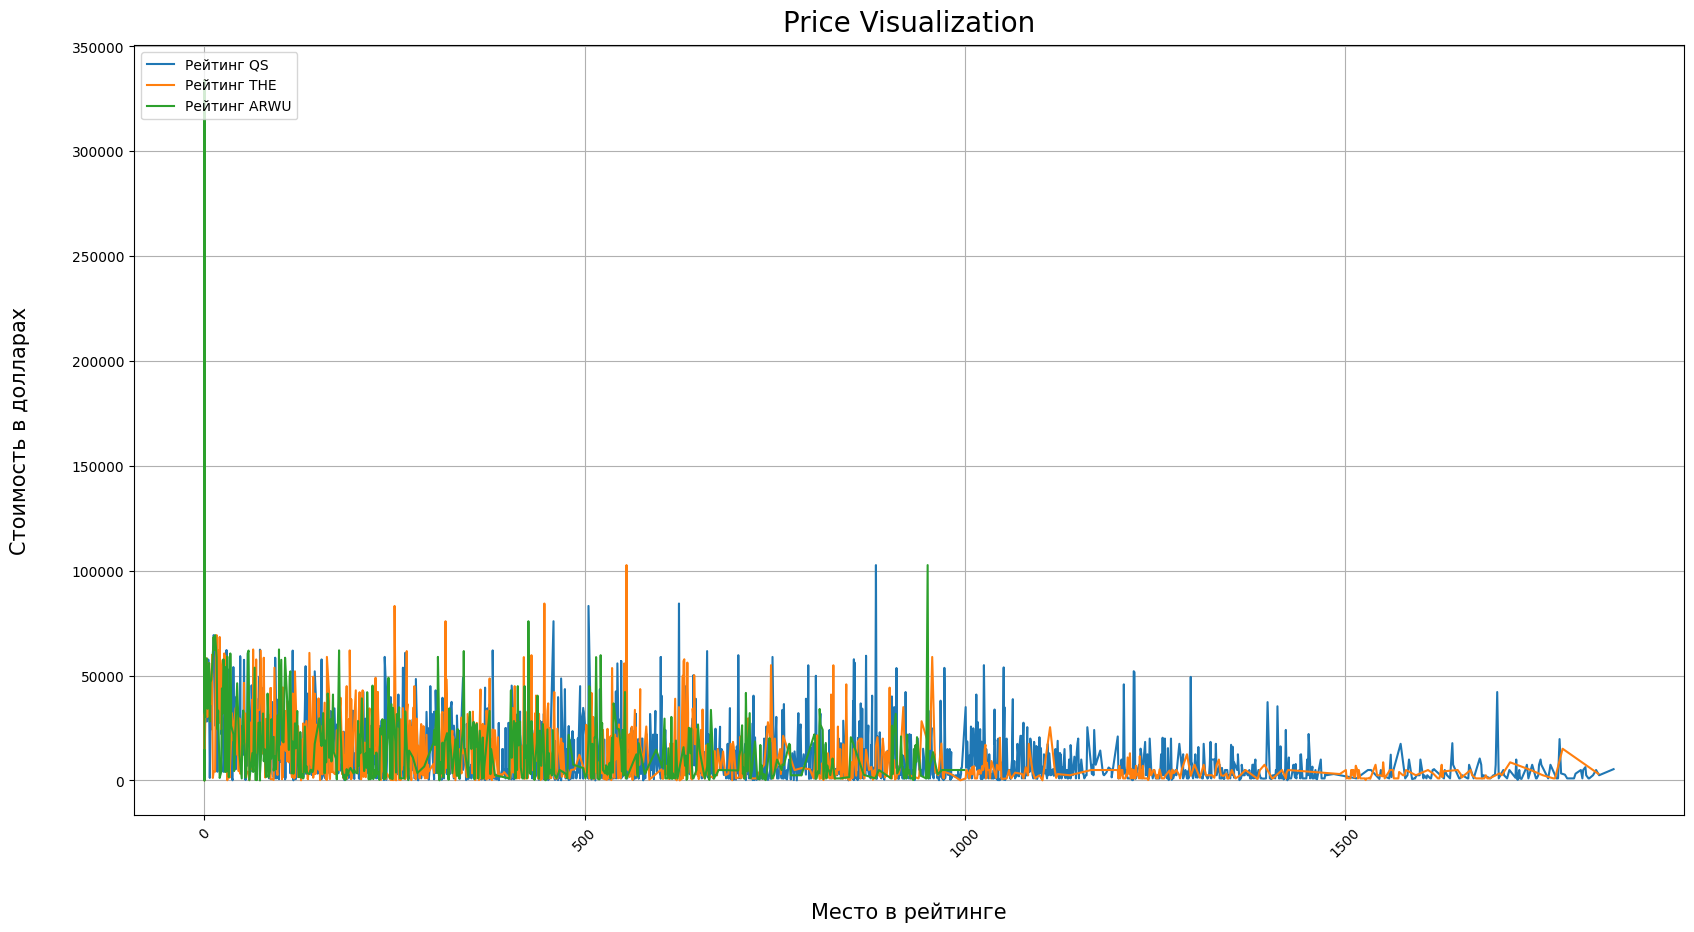

In [32]:


df = df.fillna(0) #Заполнил все NaN нулями
bchr = df[df['Бакалавриат'] != 0] #Беру только те университеты, в которых указана стоимость бакалавриата
bchr.head(10)
QS = bchr.sort_values(by='QS') # По рейтингу QS 
THE = bchr.sort_values(by='THE') # По рейтингу THE
ARWU = bchr.sort_values(by='ARWU') # По рейтингу ARWU
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(QS['QS'], QS['Бакалавриат'], label='Рейтинг QS')
plt.plot(THE['THE'], THE['Бакалавриат'], label='Рейтинг THE')
plt.plot(ARWU['ARWU'], ARWU['Бакалавриат'], label='Рейтинг ARWU')
plt.xticks(rotation=45)
ax.set_xlabel("Место в рейтинге", fontsize=15, color='black', labelpad=30)
ax.set_ylabel("Стоимость в долларах", fontsize=15, color='black', labelpad=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
plt.legend(loc='upper left')
plt.title(label='Price Visualization', loc='center', fontsize=20, fontweight=50, pad=10)
ax.grid(True)


Так ничего непонятно, давайте посмотрим отдельно каждый рейтинг в scatter и добавим данные о магистратуре и аспирантуре 

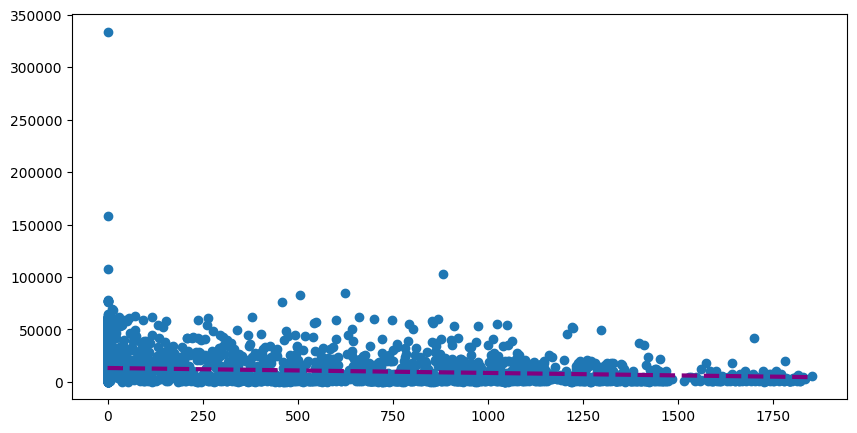

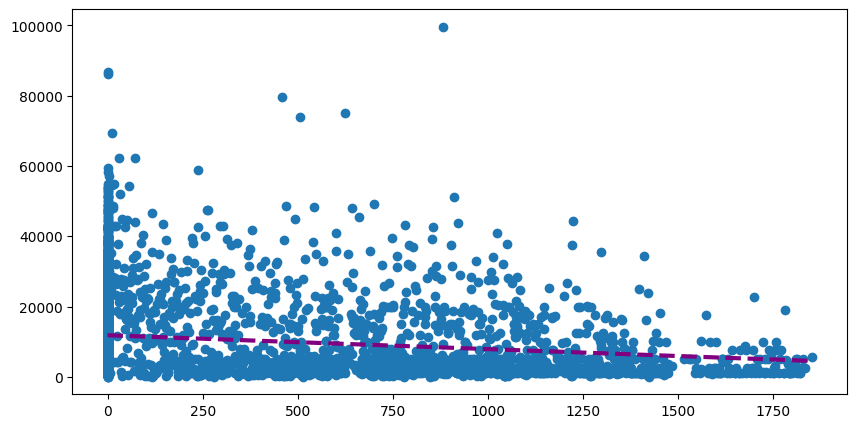

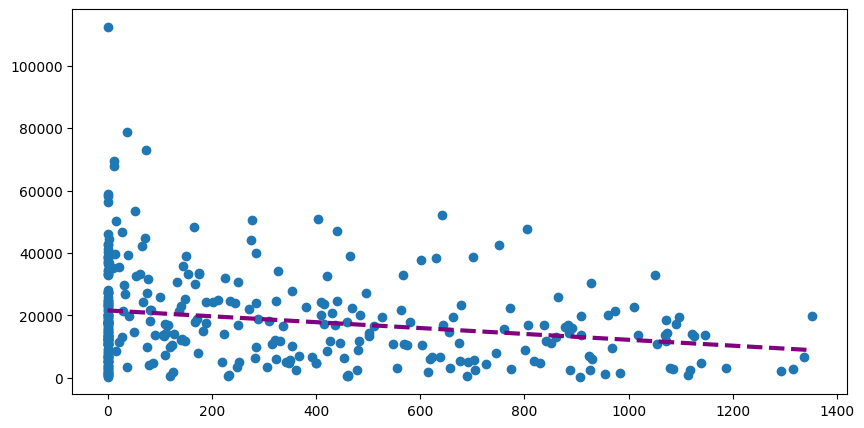

In [126]:
# Посмотрим на рейтинг QS 

mgstr = df[df['Магистратура'] != 0] #Та же идея, берем магистратуры где есть информация по цене
QS1 = mgstr.sort_values(by='QS')
THE1 = mgstr.sort_values(by='THE')
ARWU1 = mgstr.sort_values(by='ARWU')

dctr = df[df['Докторантура'] != 0] #Аспиранутры где есть информация о цене
QS2 = dctr.sort_values(by='QS')
THE2 = dctr.sort_values(by='THE')
ARWU2 = dctr.sort_values(by='ARWU') 

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(QS['QS'].tolist())
y = np.array(QS['Бакалавриат'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3) #Рисуем тренд

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(QS1['QS'].tolist())
y = np.array(QS1['Магистратура'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3) #Рисуем тренд

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(QS2['QS'].tolist())
y = np.array(QS2['Докторантура'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3) #Рисуем тренд

Видно, что связь положительная связь между номером в рейтинге и ценой действительно есть, но на бакалавриате она едва уловиема, а в аспирантуре действительно заметна. 

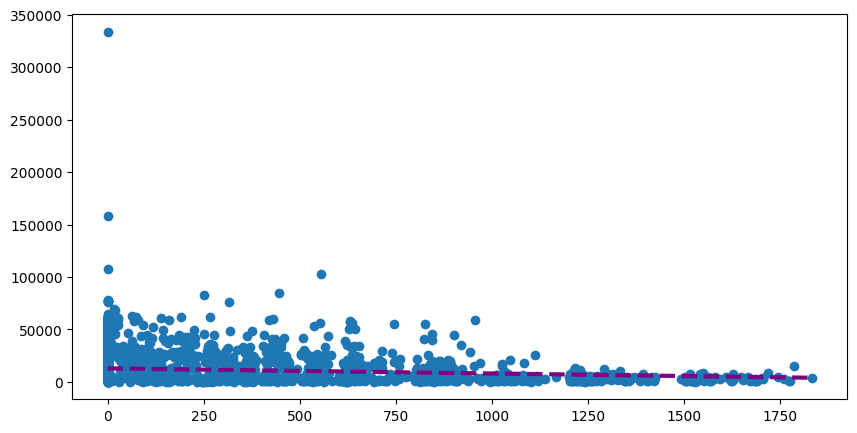

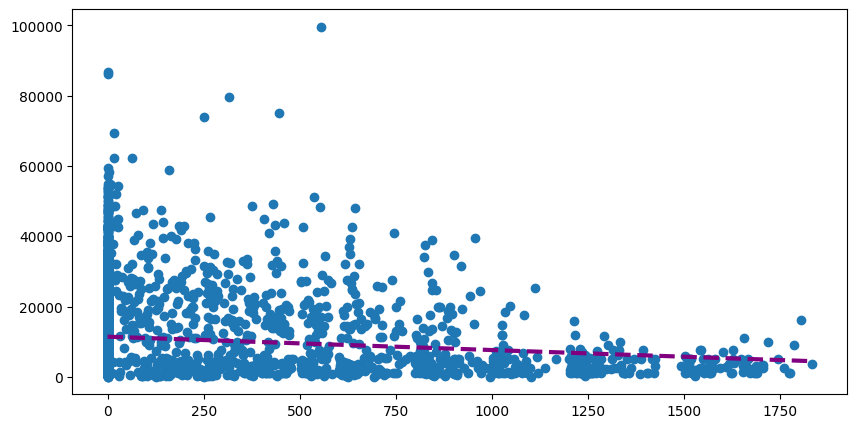

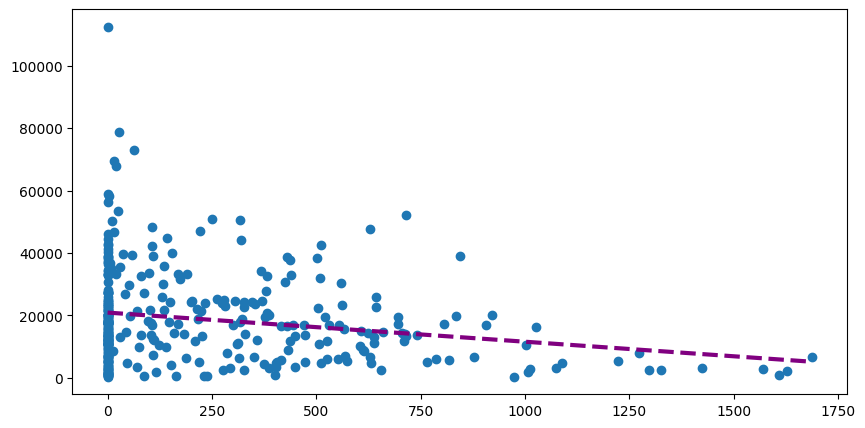

In [127]:
#Делаем тоже самое с рейтингом THE

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(THE['THE'].tolist())
y = np.array(THE['Бакалавриат'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3)

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(THE1['THE'].tolist())
y = np.array(THE1['Магистратура'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3)

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(THE2['THE'].tolist())
y = np.array(THE2['Докторантура'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3)

Такие же выводы, как и в случае с рейтингом QS

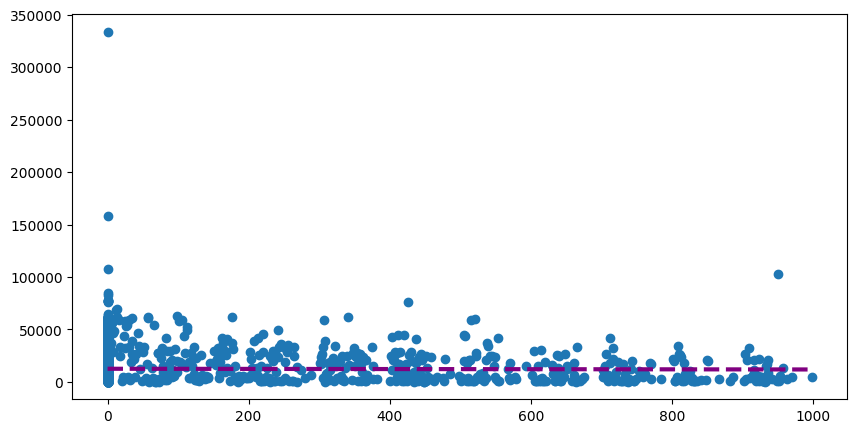

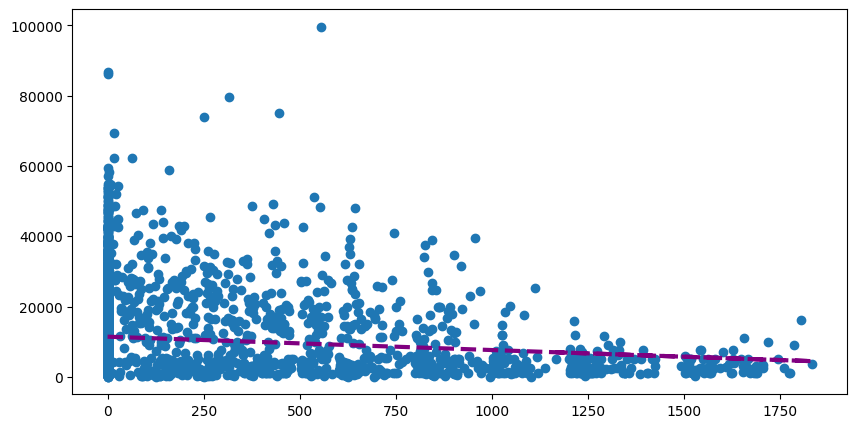

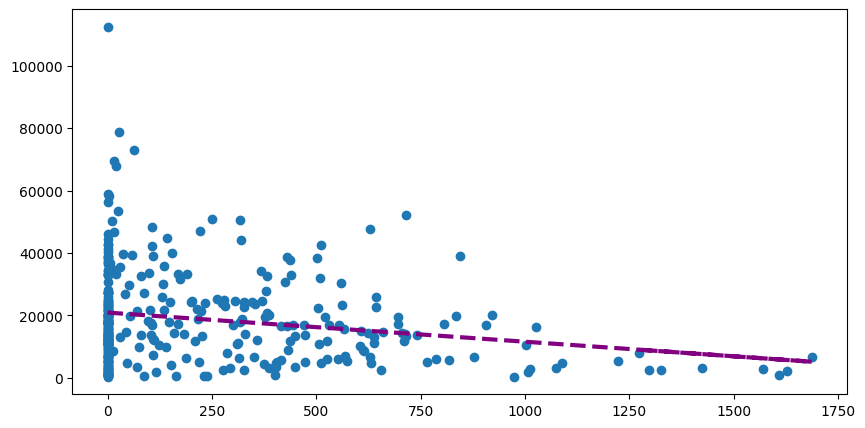

In [128]:
#Делаем тоже самое с рейтингом ARWU

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(ARWU['ARWU'].tolist())
y = np.array(ARWU['Бакалавриат'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3) 

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(ARWU1['THE'].tolist())
y = np.array(ARWU1['Магистратура'].tolist())
z = np.polyfit (x, y, 1)
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3)

fig, ax = plt.subplots(figsize=(10, 5))

x = np.array(ARWU2['THE'].tolist())
y = np.array(ARWU2['Докторантура'].tolist())
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)
plt.scatter (x, y)
plt.plot (x, p(x), color='purple', linestyle="--", linewidth= 3)

И тут, абсолютно аналогично. 

In [10]:
### FROM проект Лины Мамлеевой прошлый год
# Создание SQLite базы данных
engine = create_engine('sqlite:///uni_db.sqlite')

# Запись данных в таблицу SQL
df.to_sql('df', engine, if_exists='replace')

35641

In [11]:
%pip install ipython-sql


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
%load_ext sql

In [20]:
%sql sqlite:///uni_db.sqlite
###END FROM

Побалуемся немного с SQL, проверим, что все работает  

In [22]:
%%sql
SELECT* 
FROM df
LIMIT 5;

   sqlite:///movies_db.sqlite
 * sqlite:///uni_db.sqlite
Done.


index,Название,Место в рейтинге,Расположение,Бакалавриат,Магистратура,Докторантура,QS,THE,ARWU
0,Гарвардский университет,1,США,30281.5,30196.5,None,4.0,4.0,1.0
1,Массачусетский технологический институт,2,США,58224.0,58224.0,58224.0,1.0,3.0,3.0
2,Стэнфордский университет,3,США,57678.0,57075.0,None,5.0,2.0,2.0
3,Кембриджский университет,4,Великобритания,34218.0,27337.0,36828.5,2.0,5.0,4.0
4,Калифорнийский технологический институт,5,США,48098.0,48098.0,None,15.0,7.0,9.0


Предположим, я хочу поступить в университет, рейтинг которого по QS от 1 до 100 и цена в бакалавриате меньше чем средняя. Также, хотелось бы остаться в этом университете и продолжить учиться, поэтому хочу знать, сколько стоит там магистратура и аспирантура. Напишем такой вот SQL запрос. 

In [29]:
%%sql
SELECT*
FROM df
WHERE 1=1
AND Бакалавриат <= (SELECT AVG(Бакалавриат) FROM df)
AND Магистратура is not null
AND Докторантура is not null
AND QS between 1 and 100;

   sqlite:///movies_db.sqlite
 * sqlite:///uni_db.sqlite
Done.


index,Название,Место в рейтинге,Расположение,Бакалавриат,Магистратура,Докторантура,QS,THE,ARWU
23,Токийский университет,24,Япония,4111.0,4099.0,13105.5,28.0,29.0,27.0
40,Гейдельбергский университет,41,Германия,3245.0,3245.0,4867.5,87.0,47.0,55.0
52,Цюрихский университет,53,Швейцария,1419.0,1415.0,13682.0,91.0,80.0,59.0
54,Пекинский университет,55,Китай,4186.0,4116.5,8582.0,17.0,14.0,29.0
57,Осакский университет,58,Япония,3420.0,3792.5,4165.0,80.0,152.0,None
78,Шанхайский университет Цзяо Тун,79,Китай,12255.5,8342.0,14716.0,51.0,43.0,46.0


Посмотрим на страны и их среднюю цену на образование в бакалавриате. Но возьмем только те страны, средняя цена которых больше, чем средняя общая цена. 

In [31]:
%%sql
SELECT Расположение, AVG(Бакалавриат)
FROM df
GROUP BY 1
HAVING AVG(Бакалавриат) >= (SELECT AVG(Бакалавриат) FROM df)
;

   sqlite:///movies_db.sqlite
 * sqlite:///uni_db.sqlite
Done.


Расположение,AVG(Бакалавриат)
Австралия,26198.02380952381
Антигуа и Барбуда,12500.0
Багамы,15000.0
Барбадос,15000.0
Бахрейн,13308.0
Великобритания,20521.841981132075
Гонконг,13984.714285714286
Гренада,32745.0
Доминика,17500.0
Ирландия,14711.953125


К сожалению, взял такой сайт, где мало данных, думал, что это идеальный кейс для использования библиотеки с геоданными, но не осилил и ее. :(